## Beam Block
Testing json radar file being used in beam block calculation.

In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import pyart
from IPython.display import Image, display
get_ipython().magic(
    'install_ext https://raw.github.com/cpcloud/ipython-\
autotime/master/autotime.py')
get_ipython().magic('load_ext autotime')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR:root:Line magic function `%install_ext` not found.


In [2]:
"""
pyart.retrieve.beam_block
=======================================

Calculates partial beam block(PBB) and cumulative beam block(CBB)
by using wradlib's beamblock and geotiff functions. PBB and CBB
are then used to created flags when a certain beam block fraction
is passed. Empty radar object is created using Py-ART and then
is filled with beam block data.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    beam_block_json
    beam_block_json_flag

"""

import json
import numpy as np
import wradlib as wrl


def beam_block_json(json_file, tif_file,
                    beam_width=1.0):
    """
    Beam Block Calculation

    Parameters
    ----------
    json_file : string
        Name of json file containing radar data.
    tif_name : string
        Name of geotiff file to use for the
        calculation

    Other Parameters
    ----------------
    beam_width : float
        Radar's beam width for calculation.
        Default value is 1.0.

    Returns
    -------
    pbb_all : array
        Array of partial beam block fractions for each
        gate in each ray.
    cbb_all : array
        Array of cumulative beam block fractions for
        each gate in each ray.

    References
    ----------
    Bech, J., B. Codina, J. Lorente, and D. Bebbington,
    2003: The sensitivity of single polarization weather
    radar beam blockage correction to variability in the
    vertical refractivity gradient. J. Atmos. Oceanic
    Technol., 20, 845–855

    Heistermann, M., Jacobi, S., and Pfaff, T., 2013:
    Technical Note: An open source library for processing
    weather radar data (wradlib), Hydrol. Earth Syst.
    Sci., 17, 863-871, doi:10.5194/hess-17-863-2013
    
    Helmus, J.J. & Collis, S.M., (2016). The Python ARM
    Radar Toolkit (Py-ART), a Library for Working with
    Weather Radar Data in the Python Programming Language.
    Journal of Open Research Software. 4(1), p.e25.
    DOI: http://doi.org/10.5334/jors.119

    """

    with open(json_file) as data:
        json_data = json.load(data)
    
    rasterfile = tif_file
    data_raster = wrl.io.open_raster(rasterfile)
    proj_raster = wrl.georef.wkt_to_osr(data_raster.GetProjection())
    rastercoords, rastervalues = wrl.io.read_raster_data(rasterfile)
    sitecoords = (np.float(json_data['variables']['longitude']['data']),
                  np.float(json_data['variables']['latitude']['data']),
                  np.float(json_data['variables']['altitude']['data']))

    pbb_arrays = []
    cbb_arrays = []
    _range = np.array(json.loads(json_data['variables']['range']['data']))
    beamradius = wrl.util.half_power_radius(_range, beam_width)
    for i in range(
        len(np.array(
            json.loads(json_data['variables']['sweep_start_ray_index']['data'])))):
        index_start = np.array(
            json.loads(json_data['variables']['sweep_start_ray_index']['data']))[i]
        index_end = np.array(
            json.loads(json_data['variables']['sweep_end_ray_index']['data']))[i]

        elevs = np.array(
            json.loads(
                json_data['variables']['elevation']['data']))[index_start:index_end + 1]
        azimuths = np.array(
            json.loads(
                json_data['variables']['azimuth']['data']))[index_start:index_end + 1]
        rg, azg = np.meshgrid(_range, azimuths)
        rg, eleg = np.meshgrid(_range, elevs)
        lon, lat, alt = wrl.georef.polar2lonlatalt_n(
            rg, azg, eleg, sitecoords)

        x_pol, y_pol = wrl.georef.reproject(
            lon, lat, projection_target=proj_raster)
        polcoords = np.dstack((x_pol, y_pol))
        rlimits = (x_pol.min(), y_pol.min(), x_pol.max(), y_pol.max())
        # Clip the region inside our bounding box
        ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
        rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
        rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]
        # Map rastervalues to polar grid points
        polarvalues = wrl.ipol.cart2irregular_spline(
            rastercoords, rastervalues, polcoords)

        pbb = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
        pbb = np.ma.masked_invalid(pbb)
        pbb_arrays.append(pbb)
        maxindex = np.nanargmax(pbb, axis=1)
        cbb = np.copy(pbb)
        # Iterate over all beams
        for ii, index in enumerate(maxindex):
            premax = 0.
            for jj in range(index):
                # Only iterate to max index to make this faster
                if pbb[ii, jj] > premax:
                    cbb[ii, jj] = pbb[ii, jj]
                    premax = cbb[ii, jj]
                else:
                    cbb[ii, jj] = premax
            # beyond max index, everything is max anyway
            cbb[ii, index:] = pbb[ii, index]
        cbb_arrays.append(cbb)
    pbb_all = np.ma.concatenate(pbb_arrays)
    cbb_all = np.ma.concatenate(cbb_arrays)
    return pbb_all, cbb_all

def beam_block_flag(pbb_all, cbb_all, pbb_threshold,
                    cbb_threshold):
    """ Takes PBB and CBB arrays created from the
    beam_block function and user chosen thresholds
    to create and array of 1s and 0s, 1 is a flagged gate
    where the fraction value is past the threshold. """
    pbb_flags = np.empty_like(pbb_all)
    pbb_flags[pbb_all > 0.95] = 3
    pbb_flags[(pbb_all > 0.05) & (pbb_all < 0.95)] = 2
    pbb_flags[pbb_all < 0.05] = 0
    
    cbb_flags = np.empty_like(cbb_all)
    cbb_flags[cbb_all > 0.95] = 3
    cbb_flags[(cbb_all > 0.05) & (cbb_all < 0.95)] = 2
    cbb_flags[cbb_all < 0.05] = 0
    return pbb_flags, cbb_flags

def arrays_to_dict(pbb_all, cbb_all):
    """ Function that takes the PBB and CBB arrays
    and turns them into dictionaries to be used and added
    to the pyart radar object. """
    pbb_dict = {}
    pbb_dict['coordinates'] = 'elevation, azimuth, range'
    pbb_dict['units'] = 'unitless'
    pbb_dict['data'] = pbb_all
    pbb_dict['standard_name'] = 'partial_beam_block'
    pbb_dict['long_name'] = 'Partial Beam Block Fraction'
    pbb_dict['comment'] = 'Partial beam block fraction due to terrain'

    cbb_dict = {}
    cbb_dict['coordinates'] = 'elevation, azimuth, range'
    cbb_dict['units'] = 'unitless'
    cbb_dict['data'] = cbb_all
    cbb_dict['standard_name'] = 'cumulative_beam_block'
    cbb_dict['long_name'] = 'Cumulative Beam Block Fraction'
    cbb_dict['comment'] = 'Cumulative beam block fraction due to terrain'
    return pbb_dict, cbb_dict

def flags_to_dict(pbb_flags, cbb_flags):
    """ Function that takes the PBB_flag and CBB_flag
    arrays and turns them into dictionaries to be used
    and added to the pyart radar object. """
    pbb_flag_dict = {}
    pbb_flag_dict['units'] = 'unitless'
    pbb_flag_dict['data'] = pbb_flags
    pbb_flag_dict['standard_name'] = 'partial_beam_block_flag'
    pbb_flag_dict['long_name'] = 'Partial Beam Block Flag'
    pbb_flag_dict['comment'] = 'Partial beam block fraction flag, ' \
                            '1 for flagged values, 0 for non-flagged.'

    cbb_flag_dict = {}
    cbb_flag_dict['units'] = 'unitless'
    cbb_flag_dict['data'] = cbb_flags
    cbb_flag_dict['standard_name'] = 'cumulative_beam_block_flag'
    cbb_flag_dict['long_name'] = 'Cumulative Beam Block Flag'
    cbb_flag_dict['comment'] = 'Cumulative beam block fraction flag, ' \
                            '1 for flagged values, 0 for non-flagged.'
    return pbb_flag_dict, cbb_flag_dict

time: 147 ms


In [3]:
def empty_radar_beam_block_ppi(ngates, rays_per_sweep, nsweeps,
                               lon, lat, alt, range_start,
                               gate_space, elevations):
    """ Creates a radar object with no fields based on
    user inputed dimensions. The empty radar is to then
    be used to add PBB, CBB and the flags for both. """
    radar = pyart.testing.make_empty_ppi_radar(
        ngates, rays_per_sweep, nsweeps)
    radar.elevation['data'] = np.array([elevations] * rays_per_sweep)
    radar.longitude['data'] = np.array([lon])
    radar.latitude['data'] = np.array([lat])
    radar.altitude['data'] = np.array([alt])
    radar.azimuth['data'] = np.linspace(0, 360, rays_per_sweep)
    radar.range['data'] = np.linspace(
        range_start, (ngates - 1)*gate_space + range_start, ngates)
    radar.fixed_angle['data'] = elevations
    radar.metadata['instrument_name'] = 'beam_block_radar_object'
    return radar

def empty_radar_beam_block_rhi(ngates, rays_per_sweep, nsweeps,
                               lon, lat, alt, range_start,
                               gate_space, azimuth, elev_start,
                               elev_end):
    """ Creates a radar object with no fields based on
    user inputed dimensions. The empty radar is to then
    be used to add PBB, CBB and the flags for both. """
    radar = pyart.testing.make_empty_rhi_radar(
        ngates, rays_per_sweep, nsweeps)
    nrays = rays_per_sweep * nsweeps
    radar.longitude['data'] = np.array([lon])
    radar.latitude['data'] = np.array([lat])
    radar.altitude['data'] = np.array([alt])
    # radar.azimuth['data'] = np.linspace(0, 360, rays_per_sweep)
    radar.range['data'] = np.linspace(
        range_start, (ngates - 1)*gate_space + range_start, ngates)
    radar.elevation['data'] = np.linspace(elev_start, elev_end, nrays)
    radar.azimuth['data'] = np.array([azimuth] * nrays)
    radar.fixed_angle['data'] = np.array([azimuth])
    radar.metadata['instrument_name'] = 'beam_block_radar_object'
    return radar

time: 17.1 ms


In [4]:
# sitecoords = (-28.0257, 39.0916, 40.0)
elevations = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 10.0, 11.0, 15.0,
                          20.0, 30.0, 40.0])
radar_ppi = empty_radar_beam_block_ppi(700, 430, 1, -28.0257,
                                       39.0916, 40.0, 0, 100,
                                       elevations=2.0)
tif_name = '/home/zsherman/beam_block/data/dtm_gra.tif'

time: 2.16 ms


In [5]:
azimuth = 147
radar_rhi = empty_radar_beam_block_rhi(1073, 990, 1, -28.0257,
                                       39.0916, 40.0, 0, 100,
                                       azimuth, 0.8, 90)

time: 2.69 ms


In [6]:
_range = radar_ppi.range['data']
sweep_start = radar_ppi.sweep_start_ray_index['data']
sweep_end = radar_ppi.sweep_end_ray_index['data']
az = radar_ppi.azimuth['data']
elev = radar_ppi.elevation['data']
fix_angle = radar_ppi.fixed_angle['data']
time = radar_ppi.time['data']

time: 2.71 ms


In [7]:
my_object = {
    'variables' : {
        'time' : {
            'calendar' : 'gregorian',
            'data' : json.dumps(time.tolist()),
            'long_name' : 'time_in_seconds_since_volume_start',
            'standard_name' : 'time',
            'units' : 'seconds since 1989-01-01T00:00:01Z'
            },
        'altitude' : {
            'data' : 40.0,
            'units' : 'meters',
            'positive' : 'up',
            'long_name' : 'Altitude',
            'standard_name' : 'Altitude'
            },
        'azimuth' : {
            'data' : json.dumps(az.tolist()),
            'comment' : 'Azimuth of antenna relative to true north',
            'long_name' : 'azimuth_angle_from_true_north',
            'units' : 'degrees',
            'standard_name' : 'beam_azimuth_angle',
            'axis' : 'radial_azimuth_coordinate'
            },
        'elevation' : {
            'data' : json.dumps(elev.tolist()),
            'comment' : 'Elevation of antenna relative to the horizontal plane',
            'long_name' : 'elevation_angle_from_horizontal_plane',
            'units' : 'degrees',
            'standard_name' : 'beam_elevation_angle',
            'axis' : 'radial_elevation_coordinate'
            },
        'fields' : {   
            },
        'fixed_angle' : {
            'data' : json.dumps(fix_angle),
            'units' : 'degrees',
            'long_name' : 'Target angle for sweep',
            'standard_name' : 'target_fixed_angle'
            },
        'latitude' : {
            'data' : 39.0916,
            'units' : 'degrees_north',
            'long_name' : 'Latitude',
            'standard_name' : 'Latitude'
            },
        'longitude' : {
            'data' : -28.0257,
            'units' : 'degrees_east',
            'long_name' : 'Longitude',
            'standard_name' : 'Longitude'
            },
        'range' : {
            'data' : json.dumps(_range.tolist())
            },
        'scan_type' : 'ppi',
        'sweep_start_ray_index' : {
            'data' : json.dumps(sweep_start.tolist()),
            'units' : 'unitless',
            'long_name' : 'Index of first ray in sweep, 0-based'
            },
        'sweep_end_ray_index' : {
            'data' : json.dumps(sweep_end.tolist()),
            'units' : 'unitless',
            'long_name' : 'Index of last ray in sweep, 0-based'
            }
    }
    
}

time: 40.4 ms


In [8]:
json_file = '/home/zsherman/practice_json.json'
with open(json_file) as data:
    json_data = json.load(data)


_range = np.array(
    json.loads(json_data['variables']['range']['data']))
elevs = np.array(
    json.loads(json_data['variables']['elevation']['data']))
azimuths = np.array(
    json.loads(json_data['variables']['azimuth']['data']))
fixed_angle = np.array(
    np.float(json_data['variables']['fixed_angle']['data']))

index_start = np.array(
    json.loads(
        json_data['variables']['sweep_start_ray_index']['data']))
index_end = np.array(
    json.loads(
        json_data['variables']['sweep_end_ray_index']['data']))

ngates = len(_range)
nrays = len(azimuths)
nsweeps = len(index_start)

time = np.array(
    json.loads(json_data['variables']['time']['data']))

lon = np.array(
    np.float(json_data['variables']['longitude']['data']))
lat = np.array(
    np.float(json_data['variables']['latitude']['data']))
alt = np.array(
    np.float(json_data['variables']['altitude']['data']))

radar = pyart.testing.make_empty_ppi_radar(ngates, 1, nsweeps)

radar.metadata = {'instrument_name': 'beam block'}

radar.nrays = nrays
radar.time['data'] = time
radar.range['data'] = _range.astype('float32')

radar.latitude['data'] = lat.astype('float64')
radar.longitude['data'] = lon.astype('float64')
radar.altitude['data'] = alt.astype('float64')

radar.sweep_number['data'] = np.arange(nsweeps, dtype='int32')
radar.sweep_start_ray_index['data'] = index_start.astype('int32')
radar.sweep_end_ray_index['data'] = index_end.astype('int32')

radar.fixed_angle['data'] = fixed_angle.astype('float32')
radar.azimuth['data'] = azimuths.astype('float32')
radar.elevation['data'] = elevs.astype('float32')

time: 24.8 ms


In [9]:
practice_radar = json.dumps(my_object)
practice_json = json.loads(practice_radar)

time: 1.95 ms


In [10]:
with open('/home/zsherman/practice_json.json', 'w') as outfile:
    json.dump(my_object, outfile, sort_keys=True, indent=4,
               ensure_ascii=False)

time: 3.04 ms


In [11]:
with open('/home/zsherman/practice_json.json') as data_file:    
    data = json.load(data_file)

time: 1.49 ms


In [12]:
var = practice_json['variables']

time: 2.57 ms


In [13]:
_range = np.array(json.loads(var['range']['data']))

time: 1.49 ms


In [14]:
var['azimuth']['data']

'[0.0, 0.8391608391608392, 1.6783216783216783, 2.5174825174825175, 3.3566433566433567, 4.195804195804196, 5.034965034965035, 5.874125874125874, 6.713286713286713, 7.5524475524475525, 8.391608391608392, 9.23076923076923, 10.06993006993007, 10.90909090909091, 11.748251748251748, 12.587412587412587, 13.426573426573427, 14.265734265734267, 15.104895104895105, 15.944055944055943, 16.783216783216783, 17.622377622377623, 18.46153846153846, 19.3006993006993, 20.13986013986014, 20.97902097902098, 21.81818181818182, 22.657342657342657, 23.496503496503497, 24.335664335664337, 25.174825174825173, 26.013986013986013, 26.853146853146853, 27.692307692307693, 28.531468531468533, 29.37062937062937, 30.20979020979021, 31.04895104895105, 31.888111888111887, 32.72727272727273, 33.56643356643357, 34.40559440559441, 35.24475524475525, 36.08391608391609, 36.92307692307692, 37.76223776223776, 38.6013986013986, 39.44055944055944, 40.27972027972028, 41.11888111888112, 41.95804195804196, 42.7972027972028, 43.636

time: 2.45 ms


In [15]:
pd_json = pd.read_json(
    '/home/zsherman/practice_json.json')

time: 4.67 ms


In [16]:
pd_json

,variables
altitude,"{'data': 40.0, 'positive': 'up', 'long_name': ..."
azimuth,"{'data': '[0.0, 0.8391608391608392, 1.67832167..."
elevation,"{'data': '[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
fields,{}
fixed_angle,"{'data': '2.0', 'long_name': 'Target angle for..."
latitude,"{'data': 39.0916, 'long_name': 'Latitude', 'st..."
longitude,"{'data': -28.0257, 'long_name': 'Longitude', '..."
range,"{'data': '[0.0, 100.0, 200.0, 300.0, 400.0, 50..."
scan_type,ppi
sweep_end_ray_index,"{'data': '[429]', 'long_name': 'Index of last ..."


time: 7.28 ms


In [17]:
json_file = '/home/zsherman/practice_json.json' 
pbb_all, cbb_all = beam_block_json(
    json_file, tif_name, 1.0)

time: 698 ms


/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in sqrt
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: divide by zero encountered in true_divide
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in arcsin
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)


In [18]:
pbb_json = {'paritial_beam_block' : json.dumps(pbb_all.tolist())}

time: 18.2 ms


In [19]:
data['variables']['partial_beam_block'] = {
    'data' : json.dumps(pbb_all.tolist()),
    'long_name' : 'Partial Beam Block',
    'standard_name' : 'partial_beam_block'}

time: 30.4 ms


In [20]:
#from pprint import pprint
#pprint(data)

time: 903 µs


In [21]:
pbb_array = np.array(json.loads(data['variables']['partial_beam_block']['data']), dtype=np.float)

time: 13.9 ms


In [22]:
masked_array = np.ma.masked_invalid(pbb_array)

time: 1.25 ms


In [23]:
masked_array.max()

0.99994289382776269

time: 2.21 ms


In [24]:
pbb_flags, cbb_flags = beam_block_flag(
    pbb_all, cbb_all, 0.2, 0.2)

time: 11.7 ms


/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:149: RuntimeWarning: invalid value encountered in greater
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:150: RuntimeWarning: invalid value encountered in greater
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:150: RuntimeWarning: invalid value encountered in less
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:151: RuntimeWarning: invalid value encountered in less


In [25]:
pbb_dict, cbb_dict = arrays_to_dict(
    pbb_all, cbb_all)
pbb_flag_dict, cbb_flag_dict = flags_to_dict(
    pbb_flags, cbb_flags)

time: 1.34 ms


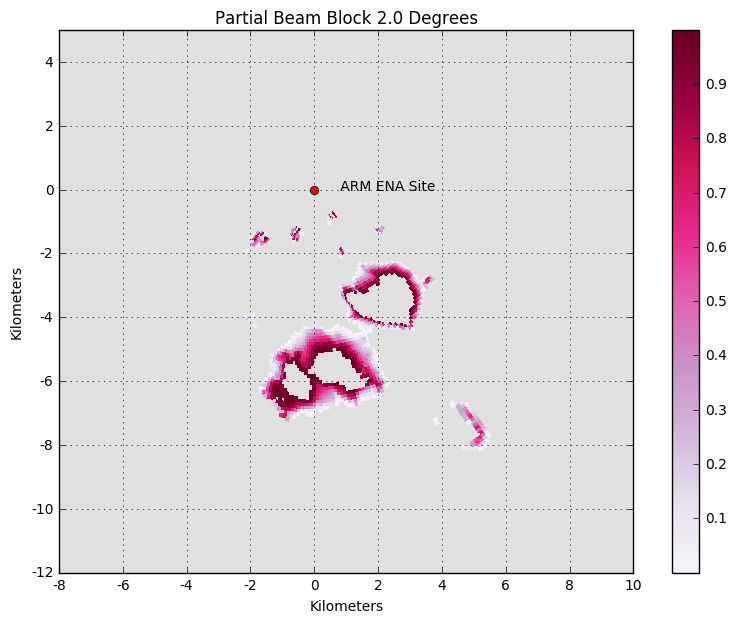

time: 542 ms


In [26]:
pbb = masked_array
cbb = cbb_all
r = np.array(json.loads(practice_json['variables']['range']['data']))
az = np.array(json.loads(practice_json['variables']['azimuth']['data']))
el = np.array(json.loads(practice_json['variables']['elevation']['data']))

fig = plt.figure(figsize=(10, 7))
ax, dem = wrl.vis.plot_ppi(pbb, r=r,
                           az=az,
                           cmap=plt.cm.PuRd)
ax.set_xlim(-8000, 10000)
ax.set_ylim(-12000, 5000)
ax.plot(0, 0, 'ro')
ax.grid(True)
ax.annotate('      ARM ENA Site', (0, 0))
ticks = (ax.get_xticks()/1000).astype(np.int)
ax.set_xticklabels(ticks)
ticks = (ax.get_yticks()/1000).astype(np.int)
ax.set_yticklabels(ticks)
ax.set_title('Partial Beam Block 2.0 Degrees')
ax.set_xlabel("Kilometers")
ax.set_ylabel("Kilometers")
ax.set_axis_bgcolor('#E0E0E0')
plt.colorbar(dem, ax=ax)
plt.show()